In [35]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path.home() / "Downloads" / "Diabetes risk prediction"
DATA_FILE = DATA_DIR / "diabetes_binary_health_indicators_BRFSS2015.csv"  # adjust name if needed

print(DATA_FILE.exists(), DATA_FILE)
df = pd.read_csv(DATA_FILE)  # only if the line above printed True
df.head()


True /Users/trisharaj/Downloads/Diabetes risk prediction/diabetes_binary_health_indicators_BRFSS2015.csv


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [36]:
import pandas as pd, numpy as np

# if df isn't in memory anymore, reload it:
# df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

FEATURES = ["HighBP","HighChol","CholCheck","BMI","Smoker","Stroke",
            "HeartDiseaseorAttack","PhysActivity","Fruits","Veggies",
            "HvyAlcoholConsump","AnyHealthcare","NoDocbcCost","GenHlth",
            "MentHlth","PhysHlth","DiffWalk","Sex","Age","Education","Income"]

# target: use Diabetes_binary if present; otherwise convert Diabetes_012→binary
if "Diabetes_binary" in df.columns:
    y = df["Diabetes_binary"].astype(int)
elif "Diabetes_012" in df.columns:
    INCLUDE_PREDIABETES = False  # set True to count prediabetes (1) as positive
    y = (df["Diabetes_012"] >= 1).astype(int) if INCLUDE_PREDIABETES else (df["Diabetes_012"] == 2).astype(int)
else:
    raise ValueError("Missing Diabetes_binary / Diabetes_012")

X = df[FEATURES].apply(pd.to_numeric, errors="coerce")
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask].astype(int)

print("Rows:", len(X), "| Pos rate:", y.mean().round(4))


Rows: 253680 | Pos rate: 0.1393


In [37]:
display(X.describe().T.iloc[:10])  # sample of stats
print("Class imbalance ->", y.value_counts(normalize=True))


,count,mean,std,min,25%,50%,75%,max
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0
Veggies,253680.0,0.811420,0.391175,0.0,1.0,1.0,1.0,1.0


Class imbalance -> Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
]).fit(X_train, y_train)


In [40]:
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(lr, method="isotonic", cv="prefit").fit(X_val, y_val)


/Users/trisharaj/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

p_val  = cal.predict_proba(X_val)[:,1]
p_test = cal.predict_proba(X_test)[:,1]

print("VAL  AUC:", roc_auc_score(y_val, p_val),  "PR-AUC:", average_precision_score(y_val, p_val))
print("TEST AUC:", roc_auc_score(y_test, p_test), "PR-AUC:", average_precision_score(y_test, p_test))

ths = np.linspace(0.05, 0.95, 91)
f1s = [f1_score(y_val, (p_val>=t).astype(int)) for t in ths]
best_t = float(ths[int(np.argmax(f1s))])
print("Chosen threshold:", round(best_t, 3), "| Test F1@t:", f1_score(y_test, (p_test>=best_t).astype(int)))


VAL  AUC: 0.82255843826757 PR-AUC: 0.3981118156592812
TEST AUC: 0.8212849968757289 PR-AUC: 0.3893851227336106
Chosen threshold: 0.22 | Test F1@t: 0.4554336188436831


In [42]:
from sklearn.metrics import confusion_matrix, classification_report
yhat_test = (p_test >= best_t).astype(int)
print(confusion_matrix(y_test, yhat_test))
print(classification_report(y_test, yhat_test, digits=3))


[[26511  6239]
 [ 1899  3403]]
              precision    recall  f1-score   support

           0      0.933     0.809     0.867     32750
           1      0.353     0.642     0.455      5302

    accuracy                          0.786     38052
   macro avg      0.643     0.726     0.661     38052
weighted avg      0.852     0.786     0.810     38052



In [43]:
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def plot_confmat(threshold=0.50, normalize="none"):
    """
    threshold: probability cutoff for positive class
    normalize: 'none' | 'true' (row) | 'pred' (col)
    """
    thr = float(threshold)
    y_pred = (p_test >= thr).astype(int)

    # normalization mode
    norm_map = {"none": None, "true": "true", "pred": "pred"}
    cm = confusion_matrix(y_test, y_pred, normalize=norm_map[normalize])
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # metrics
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    auc  = roc_auc_score(y_test, p_test)

    # plot
    plt.figure(figsize=(5.5, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix @ threshold={thr:.2f}  (normalize={normalize})")
    plt.xticks([0,1], ["Pred 0 (No Diabetes)", "Pred 1 (Diabetes)"], rotation=20)
    plt.yticks([0,1], ["True 0", "True 1"])
    # annotations
    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            txt = f"{val:.3f}" if norm_map[normalize] else f"{int([[tn, fp],[fn, tp]][i][j])}"
            plt.text(j, i, txt, ha="center", va="center", fontsize=12)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # print metrics nicely
    total = tn + fp + fn + tp
    print(f"Counts: TN={tn}  FP={fp}  FN={fn}  TP={tp}  | N={total}")
    print(f"Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  Specificity={spec:.3f}  AUC={auc:.3f}")

# Default threshold = your earlier best_t if it exists; else 0.50
default_thr = float(best_t) if "best_t" in globals() else 0.50

interact(
    plot_confmat,
    threshold=FloatSlider(value=round(default_thr,2), min=0.01, max=0.99, step=0.01, description="Threshold"),
    normalize=Dropdown(options=["none","true","pred"], value="none", description="Normalize")
);


interactive(children=(FloatSlider(value=0.22, description='Threshold', max=0.99, min=0.01, step=0.01), Dropdow…

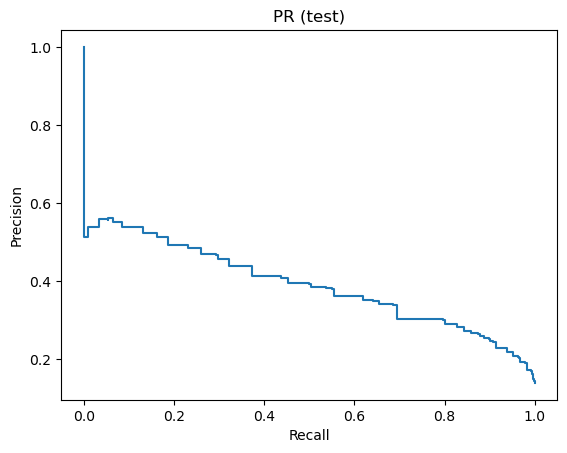

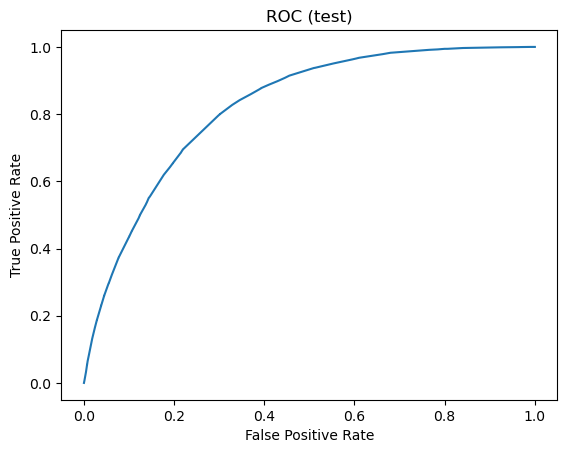

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, _ = precision_recall_curve(y_test, p_test)
plt.figure(); plt.step(rec, prec, where="post"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (test)"); plt.show()

fpr, tpr, _ = roc_curve(y_test, p_test)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC (test)"); plt.show()


In [45]:
import pandas as pd
coef = lr.named_steps["clf"].coef_[0]
pd.DataFrame({"feature": X.columns, "coef": coef, "abs": abs(coef)}).sort_values("abs", ascending=False).drop(columns="abs").head(12)


,feature,coef
13,GenHlth,0.610326
3,BMI,0.486881
18,Age,0.456274
0,HighBP,0.364505
1,HighChol,0.289911
2,CholCheck,0.245944
10,HvyAlcoholConsump,-0.165520
17,Sex,0.139271
20,Income,-0.119571
6,HeartDiseaseorAttack,0.076029


In [46]:
test_out = X_test.copy()
test_out["y_true"] = y_test.values
test_out["pred_prob"] = p_test
test_out["pred_label"] = (p_test >= best_t).astype(int)
test_out.to_csv("test_predictions.csv", index=False)
len(test_out), test_out.head()


(38052,
         HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 15722      1.0       1.0        1.0  26.0     0.0     0.0   
 138437     1.0       0.0        1.0  25.0     1.0     0.0   
 95133      0.0       0.0        1.0  29.0     1.0     0.0   
 222726     1.0       0.0        1.0  32.0     1.0     0.0   
 36020      0.0       0.0        1.0  32.0     0.0     0.0   
 
         HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  MentHlth  \
 15722                    0.0           1.0     1.0      1.0  ...      30.0   
 138437                   0.0           1.0     0.0      1.0  ...       0.0   
 95133                    0.0           0.0     1.0      0.0  ...       0.0   
 222726                   0.0           1.0     1.0      1.0  ...       0.0   
 36020                    0.0           1.0     1.0      1.0  ...       0.0   
 
         PhysHlth  DiffWalk  Sex   Age  Education  Income  y_true  pred_prob  \
 15722        0.0       1.0  0.0   8.0        6.0     5.0     

In [47]:
FEATURES_MIN = ["BMI","HighBP","HighChol","PhysActivity","GenHlth","Age","Sex"]
Xm = df[FEATURES_MIN].apply(pd.to_numeric, errors="coerce")
mask = Xm.notna().all(axis=1) & y.notna()
Xm, ym = Xm[mask], y[mask].astype(int)

from sklearn.model_selection import train_test_split
Xtr, Xtmp, ytr, ytmp = train_test_split(Xm, ym, test_size=0.30, stratify=ym, random_state=42)
Xv, Xte, yv, yte = train_test_split(Xtmp, ytmp, test_size=0.50, stratify=ytmp, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
lr_m = Pipeline([("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]).fit(Xtr, ytr)
cal_m = CalibratedClassifierCV(lr_m, method="isotonic", cv="prefit").fit(Xv, yv)

import numpy as np
p_v = cal_m.predict_proba(Xv)[:,1]; p_te = cal_m.predict_proba(Xte)[:,1]
ths = np.linspace(0.05, 0.95, 91); best_t_m = float(ths[np.argmax([f1_score(yv,(p_v>=t).astype(int)) for t in ths])])

# save a minimal bundle (no defaults needed now)
import joblib
joblib.dump({"model": cal_m, "features": FEATURES_MIN, "threshold": best_t_m}, "model_diabetes_brfss.pkl")


/Users/trisharaj/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


['model_diabetes_brfss.pkl']

In [48]:
import pandas as pd, joblib
b = joblib.load("model_diabetes_brfss.pkl")
new = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")  # or another file with same columns
probs = b["model"].predict_proba(new[b["features"]])[:,1]
preds = (probs >= b["threshold"]).astype(int)
out = new.copy()
out["pred_prob"] = probs; out["pred_label"] = preds
out.to_csv("predictions.csv", index=False)
len(out), out.head()


(253680,
    Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
 1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
 2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
 3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
 4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   
 
    HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
 0                   0.0           0.0     0.0  ...      5.0      18.0   
 1                   0.0           1.0     0.0  ...      3.0       0.0   
 2                   0.0           0.0     1.0  ...      5.0      30.0   
 3                   0.0           1.0     1.0  ...      2.0       0.0   
 4                   0.0           1.0     1.0  ...      2.0       3.0   
 
    PhysHlth  DiffWalk  Sex   Age  Education  Income  pred_prob  pred_label  
 0      15.0       1.

In [49]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=400, class_weight="balanced_subsample",
    min_samples_split=4, min_samples_leaf=2, n_jobs=-1, random_state=42
).fit(X_train, y_train)

cal_rf = CalibratedClassifierCV(rf, method="isotonic", cv="prefit").fit(X_val, y_val)
p_test_rf = cal_rf.predict_proba(X_test)[:,1]
print("RF TEST AUC:", roc_auc_score(y_test, p_test_rf), "PR-AUC:", average_precision_score(y_test, p_test_rf))


/Users/trisharaj/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


RF TEST AUC: 0.8162671698134939 PR-AUC: 0.38990920823068437


In [50]:
from sklearn.metrics import roc_auc_score, average_precision_score

scores = {
    "lr":  {"roc": roc_auc_score(y_test, p_test),
            "pr":  average_precision_score(y_test, p_test)},
    "rf":  {"roc": roc_auc_score(y_test, p_test_rf),
            "pr":  average_precision_score(y_test, p_test_rf)},
}
scores


{'lr': {'roc': np.float64(0.8212849968757289),
  'pr': np.float64(0.3893851227336106)},
 'rf': {'roc': np.float64(0.8162671698134939),
  'pr': np.float64(0.38990920823068437)}}

In [51]:
import joblib

WINNER = "lr"   
model = cal if WINNER=="lr" else cal_rf
threshold = float(best_t) if WINNER=="lr" else float(best_t_rf)

bundle = {"model": model, "features": X.columns.tolist(), "threshold": threshold}
joblib.dump(bundle, "model_diabetes_brfss.pkl")
print("Saved model_diabetes_brfss.pkl with threshold", threshold)


Saved model_diabetes_brfss.pkl with threshold 0.21999999999999997


In [52]:
import pandas as pd, joblib

def score_csv(input_csv, model_pkl="model_diabetes_brfss.pkl", output_csv="predictions.csv"):
    b = joblib.load(model_pkl)
    feats, thr = b["features"], b["threshold"]
    m = b["model"]

    df = pd.read_csv(input_csv)
    missing = [c for c in feats if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    probs = m.predict_proba(df[feats])[:,1]
    preds = (probs >= thr).astype(int)
    out = df.copy()
    out["pred_prob"] = probs
    out["pred_label"] = preds
    out.to_csv(output_csv, index=False)
    return out.head()

# example:
# score_csv("diabetes_binary_health_indicators_BRFSS2015.csv", output_csv="predictions.csv")


In [53]:
%pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [54]:
# --- load data (if df isn't already in memory) ---
import pandas as pd, numpy as np
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")  # adjust name if needed

# --- target ---
y = df["Diabetes_binary"].astype(int)  # since this file has Diabetes_binary

# --- minimal feature set (7) ---
FEATURES_MIN = ["BMI","HighBP","HighChol","PhysActivity","GenHlth","Age","Sex"]

X = df[FEATURES_MIN].apply(pd.to_numeric, errors="coerce")
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask].astype(int)

# --- split ---
from sklearn.model_selection import train_test_split
Xtr, Xtmp, ytr, ytmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
Xv, Xte, yv, yte     = train_test_split(Xtmp, ytmp, test_size=0.50, stratify=ytmp, random_state=42)

# --- model: LR + scaling + class_weight; then calibrate ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

lr = Pipeline([("sc", StandardScaler()),
               ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))]).fit(Xtr, ytr)
cal = CalibratedClassifierCV(lr, method="isotonic", cv="prefit").fit(Xv, yv)

# --- choose threshold by val F1 ---
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import numpy as np
p_v  = cal.predict_proba(Xv)[:,1]
p_te = cal.predict_proba(Xte)[:,1]

ths = np.linspace(0.05, 0.95, 91)
best_t = float(ths[np.argmax([f1_score(yv, (p_v>=t).astype(int)) for t in ths])])

print("TEST AUC:", roc_auc_score(yte, p_te), "PR-AUC:", average_precision_score(yte, p_te), "F1@t:", f1_score(yte,(p_te>=best_t).astype(int)))
best_t


/Users/trisharaj/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


TEST AUC: 0.8156736274083524 PR-AUC: 0.3807336139078632 F1@t: 0.4466991341991342


0.22999999999999998

In [55]:
import joblib, pathlib, json
bundle = {"model": cal, "features": FEATURES_MIN, "threshold": best_t}
joblib.dump(bundle, "model_diabetes_brfss.pkl")
pathlib.Path("model_diabetes_brfss.pkl").resolve()


PosixPath('/Users/trisharaj/Downloads/Diabetes risk prediction/model_diabetes_brfss.pkl')

In [56]:
import sys, sklearn, joblib
print(sys.executable)
print("sklearn:", sklearn.__version__, "joblib:", joblib.__version__)


/Users/trisharaj/Downloads/anaconda3/bin/python
sklearn: 1.6.1 joblib: 1.4.2
